<h1 style="text-align:center;">PROYECTO GREEN-LIGTH</h1>

<br>

<center>
Este modelo trata de predecir el consumo y produccion de prosumidores
</center>

### Ocultamos los warnings

In [1]:
import warnings

# Desactivamos todas las advertencias
warnings.filterwarnings('ignore')

<br>
<br>

# Importamos las tablas

### Tablas de Kaggle

Además de estas tablas, el ejercicio nos daba una tabla de predicción de tiempo, decidimos no usarla ya que tenemos una tabla con datos reales historicos

In [2]:
import pandas as pd

# Importamos las tablas que nos facilita la empresa
df_client = pd.read_csv('client.csv')
df_gas = pd.read_csv('gas_prices.csv')
df_electricity = pd.read_csv('electricity_prices.csv')
df_historical = pd.read_csv('historical_weather.csv')
df_train = pd.read_csv('train.csv')

<br>
<br>

# Análisis EDA

Realizamos un análisis EDA sobre las tablas que nos aporta el ejercicio, para comprender los datos que tenemos y las relaciones entre ellos

Ejecutamos un describe de la tabla donde tenemos nuestra variable objetivo

In [3]:
df_train.describe().round(2)

county  is_business  product_type      target  is_consumption  \
count  2018352.00   2018352.00    2018352.00  2017824.00       2018352.0   
mean         7.30         0.54          1.90      274.86             0.5   
std          4.78         0.50          1.08      909.50             0.5   
min          0.00         0.00          0.00        0.00             0.0   
25%          3.00         0.00          1.00        0.38             0.0   
50%          7.00         1.00          2.00       31.13             0.5   
75%         11.00         1.00          3.00      180.21             1.0   
max         15.00         1.00          3.00    15480.27             1.0   

       data_block_id      row_id  prediction_unit_id  
count     2018352.00  2018352.00          2018352.00  
mean          321.87  1009175.50               33.05  
std           182.63   582648.18               19.59  
min             0.00        0.00                0.00  
25%           166.00   504587.75               16.00  
50%           323.00  1009175.50               33.00  
75%           479.00  1513763.25               50.00  
max           637.00  2018351.00               68.00

*Con este describe podemos observar que en la variable target existen valores atípicos extremadamente altos*

<br>
<br>

Queriamos comprender que datos reflejaba nuestra variable objetivo

In [4]:
# Nos fijamos en un cliente en concreto para analizarlo
fecha_inicio = '2021-09-01 00:00:00'	
fecha_fin = '2021-09-03 00:00:00'
df_filtrado = df_train[(df_train['prediction_unit_id'] == 0) & (df_train['datetime'].between(fecha_inicio, fecha_fin))]

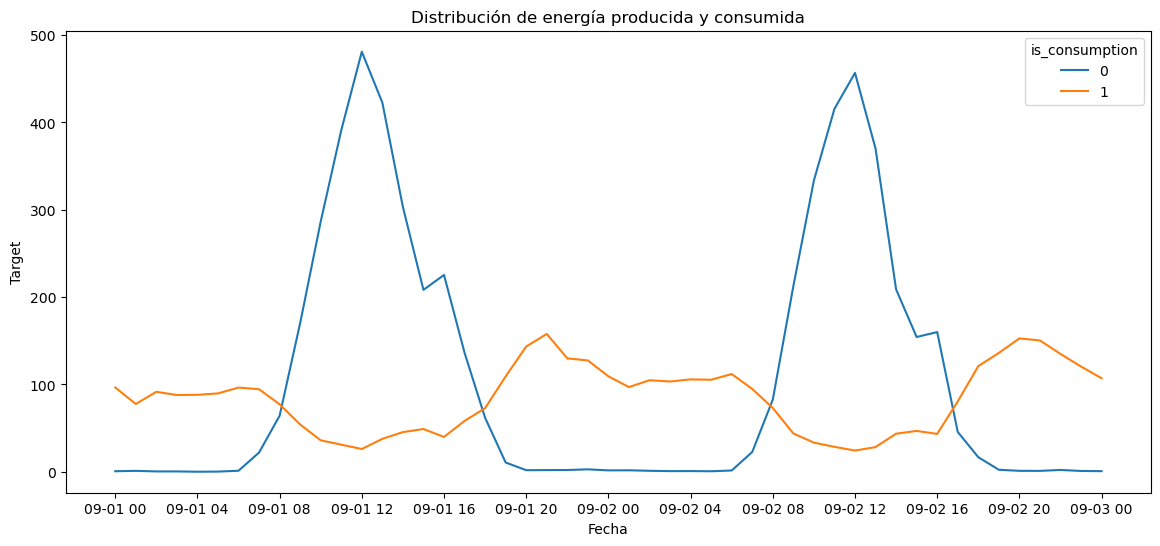

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates

df_filtrado['datetime'] = pd.to_datetime(df_filtrado['datetime'])

# Creamos un gráfico con líneas
plt.figure(figsize=(14, 6))
sns.lineplot(data=df_filtrado, x='datetime', y='target', hue='is_consumption')

# Configuramos el eje x para mostrar entre 8 y 15 fechas
locator = mdates.AutoDateLocator(minticks=8, maxticks=15)
plt.gca().xaxis.set_major_locator(locator)

plt.title('Distribución de energía producida y consumida')
plt.xlabel('Fecha')
plt.ylabel('Target')
plt.show()

*Este gráfico nos permitió identificar que cuando "is_consumption" == 0 el target (variable objetivo) indica la producción y "is_consumption" == 1 indica el consumo que requiere de la empresa de electricidad*

<br>
<br>

Veremos la producción y consumo a lo largo del tiempo

In [6]:
df_train_serie = (df_train.groupby(['datetime','is_consumption'])['target'].mean().unstack().rename({0: 'produced', 1:'consumed'}, axis=1))
df_train_serie.index = pd.to_datetime(df_train_serie.index)

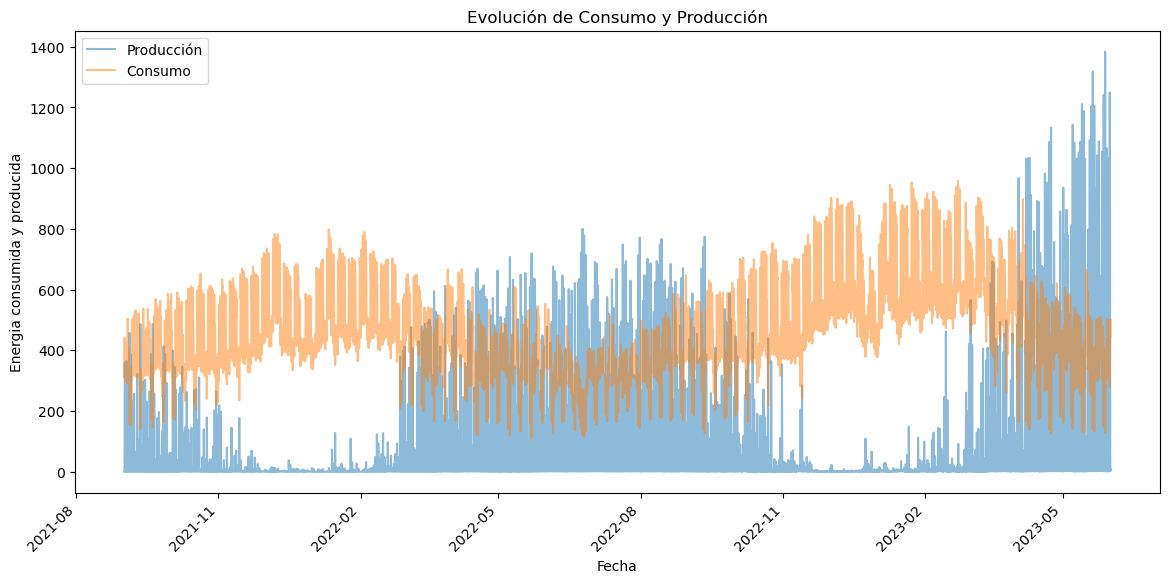

In [7]:
plt.figure(figsize=(14, 6))

# Diferenciamos entre consumida y producida
sns.lineplot(data=df_train_serie, x='datetime', y='produced', label='Producción', alpha=0.5)
sns.lineplot(data=df_train_serie, x='datetime', y='consumed', label='Consumo', alpha=0.5)

# Establecemos el locator para mostrar las fechas cada 3 meses
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=3))

plt.ylabel('Energia consumida y producida')
plt.xlabel('Fecha')
plt.xticks(rotation=45, ha='right')
plt.title('Evolución de Consumo y Producción')

plt.show()

*Podemos apreciar como la producción aumenta en los meses de verano y dismuniye en los meses de invierno, justo al contrario que el consumo*

<br>
<br>

Observaremos la frecuencia de la capacidad instalada

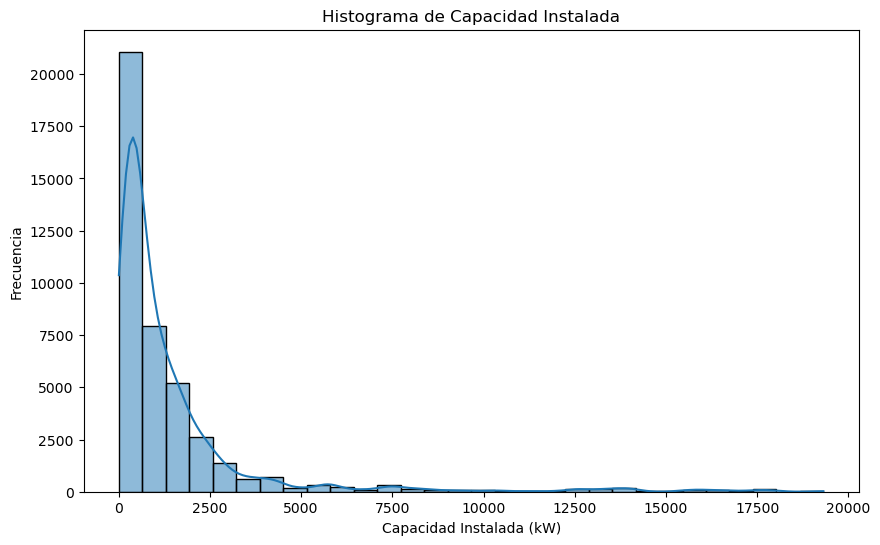

In [8]:
# Explorar la distribución de la capacidad instalada.
plt.figure(figsize=(10, 6))
sns.histplot(df_client['installed_capacity'], bins=30, kde=True)
plt.title('Histograma de Capacidad Instalada')
plt.xlabel('Capacidad Instalada (kW)')
plt.ylabel('Frecuencia')
plt.show()

*Este gráfico indica que por norma general los clientes suelen tener poca capacidad instalada, aunque hay algunos que tienen mucha capacidad*

<br>
<br>

Analizaremos el precio de la electricidad durante las fechas que tenemos datos

In [9]:
# Resampleamos a meses
df_electricity['forecast_date'] = pd.to_datetime(df_electricity['forecast_date'])
df_resampled = df_electricity.set_index('forecast_date').resample('M').mean().reset_index()

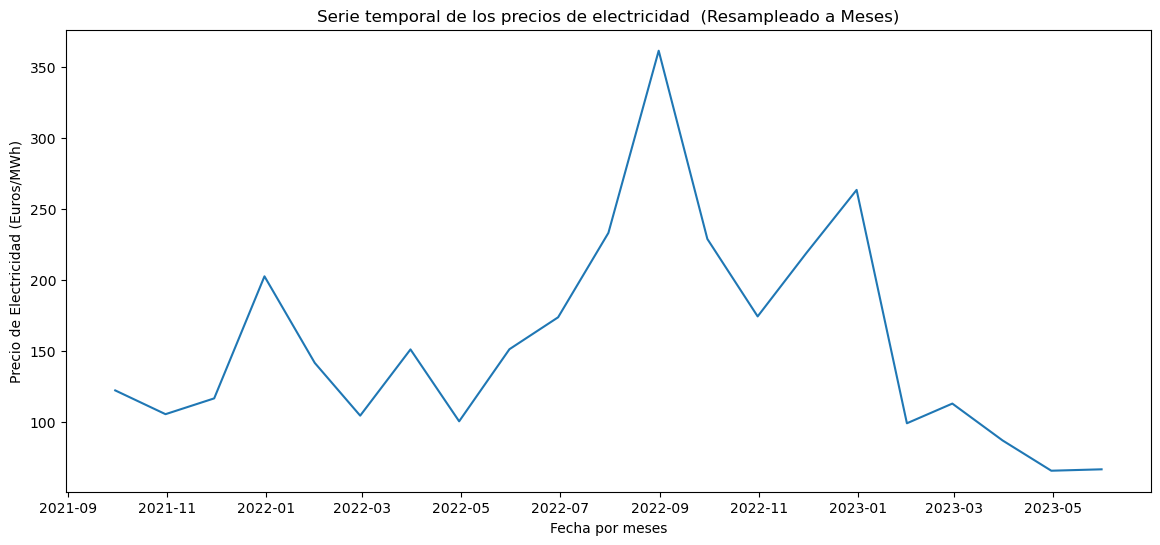

In [10]:
# Time Series Plot de Precios de Electricidad:
plt.figure(figsize=(14, 6))

sns.lineplot(data=df_resampled, x='forecast_date', y='euros_per_mwh')
plt.title('Serie temporal de los precios de electricidad  (Resampleado a Meses)')
plt.xlabel('Fecha por meses')
plt.ylabel('Precio de Electricidad (Euros/MWh)')
plt.show()

*Esta gráfica nos permite ver el comportamiento del precio de la electricidad a lo largo de los meses sobre los que tenemos datos*

*Veamos como es su evolución en un día en concreto*

In [11]:
# Delimitamos el día
fecha_inicio_elec = '2023-03-01 00:00:00'	
fecha_fin_elec = '2023-03-01 23:00:00'
df_elec = df_electricity[df_electricity['forecast_date'].between(fecha_inicio_elec, fecha_fin_elec)]

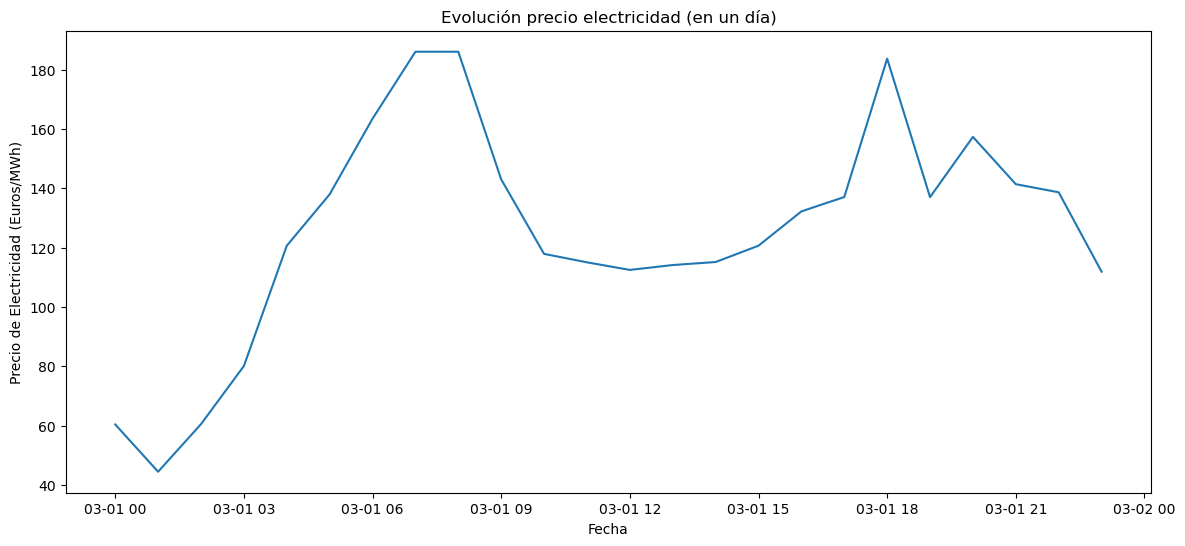

In [12]:
# Convertimos a formato fecha-hora
df_elec['forecast_date'] = pd.to_datetime(df_elec['forecast_date'])

# Creamos un gráfico con líneas
plt.figure(figsize=(14, 6))
sns.lineplot(data=df_elec, x='forecast_date', y='euros_per_mwh')

# Configuramos el eje x para mostrar entre 8 y 12 fechas
locator = mdates.AutoDateLocator(minticks=8, maxticks=12)
plt.gca().xaxis.set_major_locator(locator)

plt.title('Evolución precio electricidad (en un día)')
plt.xlabel('Fecha')
plt.ylabel('Precio de Electricidad (Euros/MWh)')
plt.show()

<br>
<br>

Ahora analizaremos los precios del gas

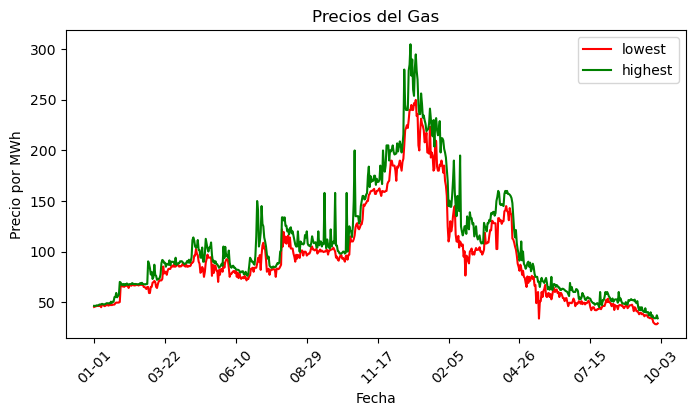

In [13]:
from matplotlib.ticker import MaxNLocator

# Analizar la evolución temporal de los precios mínimos y máximos de gas.

fig, ax = plt.subplots(1, 1, figsize=(8, 4))
sns.lineplot(data=df_gas, x='forecast_date', y='lowest_price_per_mwh', ax=ax, label='lowest', color='red')
sns.lineplot(data=df_gas, x='forecast_date', y='highest_price_per_mwh', ax=ax, label='highest', color='green')

# Configuramos el formato de las fechas en el eje x
ax.xaxis.set_major_locator(MaxNLocator(nbins=10))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))

# Rotamos las etiquetas para una mejor legibilidad
plt.xticks(rotation=45)

ax.legend()
ax.set_ylabel('Precio por MWh')
ax.set_xlabel('Fecha')
ax.set_title('Precios del Gas')
plt.show()

*Podemos apreciar un claro incremento a finales de 2021 y desde entonces una clara tendencia descendente*

<br>
<br>

Mostraremos las principales variables climatologicas, en un día en verano y otro día en invierno

In [14]:
# Delimitamos el inicio y fin de cada día
fecha_inicio_d1 = '2022-07-01 00:00:00'	
fecha_fin_d1 = '2022-07-01 23:00:00'
df_day1 = df_historical[df_historical['datetime'].between(fecha_inicio_d1, fecha_fin_d1)]

fecha_inicio_d2 = '2022-12-20 00:00:00'	
fecha_fin_d2 = '2022-12-20 23:00:00'
df_day2 = df_historical[df_historical['datetime'].between(fecha_inicio_d2, fecha_fin_d2)]

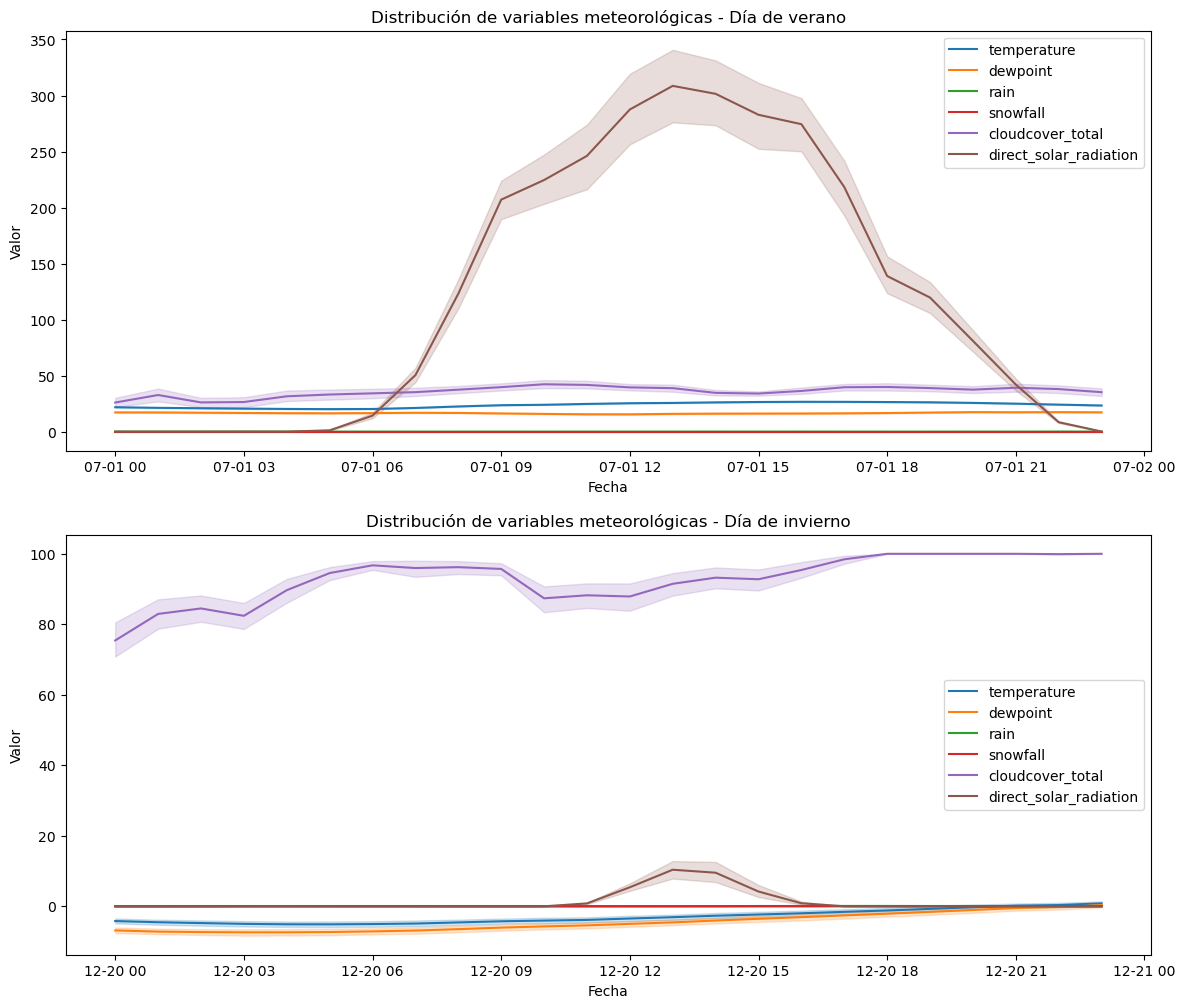

In [15]:
# Convertir 'datetime' a formato datetime
df_day1['datetime'] = pd.to_datetime(df_day1['datetime'])
df_day2['datetime'] = pd.to_datetime(df_day2['datetime'])

# Creamos subgráficos (2 filas, 1 columna)
fig, axs = plt.subplots(2, 1, figsize=(14, 12), sharex=False)

# Columnas a incluir en el eje y
columnas_y = ['temperature', 'dewpoint', 'rain', 'snowfall', 'cloudcover_total', 'direct_solar_radiation']

# Iteramos sobre las columnas y añadimos líneas al gráfico para el día 1
for columna in columnas_y:
    sns.lineplot(data=df_day1, x='datetime', y=columna, label=columna, ax=axs[0])

# Iteramos sobre las columnas y añadimos líneas al gráfico para el día 2
for columna in columnas_y:
    sns.lineplot(data=df_day2, x='datetime', y=columna, label=columna, ax=axs[1])

# Ajustes de los subgráficos
axs[0].set_title('Distribución de variables meteorológicas - Día de verano')
axs[0].set_xlabel('Fecha')
axs[0].set_ylabel('Valor')
axs[0].legend()

axs[1].set_title('Distribución de variables meteorológicas - Día de invierno')
axs[1].set_xlabel('Fecha')
axs[1].set_ylabel('Valor')
axs[1].legend()

plt.show()

*Como podíamos preveer, en verano es mucho mayor la radiación y baja en invierno, ya que sube la nubosidad, esto lo podemos relacionar con la evolución de la producción, la cual tiene el mismo comportamiento que la radiación*

<br>
<br>

### Tabla adicional

En este punto teniamos un problema, no podiamos unir la tabla "df_historical" con "df_train" ya que la primera no tenia la variable "county", en su lugar tenia dos variables, "longitude" y "latitude", por lo que debiamos encontrar la manera de asociar esos datos a un county en concreto y eso nos permite hacer esta tabla

Esta tabla nos permite unir los datos de las tablas de tiempo con la tabla de train, mediante el "county"

In [16]:
# Importamos una tabla que asocia la longitud y latitud con county, esta tabla la podemos encontrar en kaggle
df_location = (pd.read_csv("county_lon_lats.csv").drop(columns = ["Unnamed: 0"]))

In [17]:
import plotly.express as px

df_location['size'] = 5

fig = px.scatter_mapbox(
    df_location, 
    lat="latitude", 
    lon="longitude", 
    color="county",
    size='size',
    zoom=6,
    title='Weather Stations Locations'
)

fig.update_layout(mapbox_style="open-street-map")
fig.update_layout(margin={"r":0,"t":30,"l":0,"b":0})
fig.show()

*En este mapa podemos ver las diferentes localizaciones de los countys, los cuales hemos asociado segun su longitud y latitud*

<br>
<br>

# Importamos nuestras propias funciones

Creamos un archivo .py con todas las funciones, las importamos para poder usarlas

In [18]:
from funciones import *

<br>
<br>

# Web-Scrapping

Utilizamos web scrapping para obtener los dias festivos de estonia, y crear una nueva columna que indique si es festivo

La función get_holiday procede de nuestro archivo .py, incluye otra función en su interior que nos permite modificar la fecha a formato ingles

In [19]:
# Ejecutamos la función para cada año y lo agregamos todo a una lista
holiday_2021 = get_holiday(2021)
holiday_2022 = get_holiday(2022)
holiday_2023 = get_holiday(2023)

holiday = holiday_2021 + holiday_2022 + holiday_2023

*Podriamos obtener los festivos usando la libreria "holidays", pero era una manera de demostrar en el proyecto que podemos hacer web-scrapping*

<br>
<br>

# Transformación de tablas

El archivo .py en el que almacenamos todas las funciones que nos permite modificar las tablas, ahora veremos que cambio se producen en cada tabla

**df_train:**
- Creación de nuevas columnas a partir de las existentes
    - Separación de la fecha en diferentes columnas
    - Agregación de columna que indica si es festivo
    - Creación de columnas lagged-target por días
    - Tendencias de la columna target
    - Columnas que indican si es fin de semana o día de trabajo
- Eliminación de columnas no deseadas 

<br>

**df_electricity:**
- Creación de nuevas columnas a partir de las existentes
    - Separación de la fecha en diferentes columnas
    - Columnas shifteadas con precios anteriores
- Eliminación de columnas no deseadas 

<br>

**df_gas:**
- Creación de nuevas columnas a partir de las existentes
- Eliminación de columnas no deseadas 

<br>

**df_client:**
- Creación de nuevas columnas a partir de las existentes 

<br>

**df_historical:**
- Creación de nuevas columnas a partir de las existentes
    - StandardScaler, PCA y KMeans para obtener columnas categóricas sobre el tiempo
    - Creación de columnas (rolling mean)
- Unión con tabla "df_location" para añadir la columna "county"
- Agrupación por "county" y "datetime", algunas columnas por media y otras por moda
- Eliminación de columnas no deseadas

In [20]:
# Ejecutamos las funciones
df_train = train_transformation(df_train, holiday)
df_electricity = electricity_transformation(df_electricity)
df_gas = gas_transformation(df_gas)
df_client = client_transformation(df_client)
df_historical = historical_transformation(df_historical, df_location)

<br>
<br>

# Union de tablas

Unimos todas las tablas para crear el DataFrame final con el que trabajaremos, para ello unimos solo las columnas que nos interesan de cada tabla

In [21]:
# Union de tablas
df = pd.merge(df_train, df_electricity[['datetime', 'euros_per_mwh', 'price_per_day', 'price_diff_with_previous', 'previous_price_t-hour', 'previous_price_t-day', 'previous_price_t-week', 'previous_price_t-month' ]], how='left', on=['datetime'])
df = pd.merge(df, df_gas[['date', 'lowest_price_per_mwh', 'highest_price_per_mwh', 'average_price', 'price_difference']], how='left', on=['date'])
df = pd.merge(df, df_client[['product_type', 'county', 'eic_count', 'installed_capacity', 'is_business', 'date', 'capacity_ratio']],  how='left', on=['date', 'county', 'is_business', 'product_type'])
columnas_a_eliminar = ['latitude', 'longitude', 'hour', 'day', 'month']
df = pd.merge(df, df_historical.drop(columnas_a_eliminar, axis=1), how='left', on=['county', 'datetime'])

<br>
<br>

# Tratamiento del Dataset

Utilizamos esta función para hacer ciertos cambios en el DataFrame final

- Creación de nuevas variables con columnas de diferentes tablas
    - Columnas de lagged-target con las categoricas del tiempo
- Modificación del tipo de datos de algunas variables
- Eliminación de nulos
- Eliminación de columnas que no aportan valor al modelo

In [22]:
df_total = df_transformation_total(df)

*Los nulos se generaban al laggear el target, ya que no encontraba coincidencias tan especificas en el pasado*

*Por falta de tiempo y teniendo en cuenta que el porcentaje de nulos es muy pequeño en relación a la gran cantidad de datos que tenemos decidimos eliminar cualquier fila que tuviera un nulo, en un futuro podríamos probar diferentes métodos de tratamiento de nulos*

<br>
<br>

# Separacion en Producción y Consumo

Para obtener una mejor predicción decidimos usar dos modelos diferentes, uno para producción y otro para consumo, ya que las variables afectan de manera diferente para cada cosa

Para ello usamos la columna "is_consumption" que nos indica "0" para producción y "1" para consumo

In [23]:
# Produccion
df_produced = df_total[df_total['is_consumption'] == 0]


# Consumo
df_consumed = df_total[df_total['is_consumption'] == 1]

<br>
<br>

# Train-Test Split

Para el test usaremos los datos que pide predecir el ejercicio de kaggle, el resto lo usaremos para entrenar

In [24]:
# Producción
df_test_prod = df_produced[df_produced['row_id'].between(2005872, 2018351)]
df_train_prod = df_produced[~df_produced['row_id'].between(2005872, 2018351)]


# Consumo
df_test_con = df_consumed[df_consumed['row_id'].between(2005872, 2018351)]
df_train_con = df_consumed[~df_consumed['row_id'].between(2005872, 2018351)]

<br>

### Eliminacion row_id

Una vez separado en train y test podemos eliminar las columnas de row_id de todos los dataframes

Antes de eliminar las columnas dejamos guardadas en una variable los rows_ids de ambos test, lo cual nos será util para unir al submission de kaggle

In [25]:
# Guardamos la columna row_id de ambos test
row_id_test_prod = df_test_prod.row_id
row_id_test_con = df_test_con.row_id

# Eliminamos las columnas
df_test_prod = df_test_prod.drop('row_id', axis=1)
df_train_prod = df_train_prod.drop('row_id', axis=1)
df_test_con = df_test_con.drop('row_id', axis=1)
df_train_con = df_train_con.drop('row_id', axis=1)

<br>
<br>

# Modelo de Producción

### Preparacion del dataset

In [26]:
# Obtenemos la X y la Y para train y para test

x_train_prod = df_train_prod.drop(columns=['target'])
y_train_prod = df_train_prod.target

x_test_prod = df_test_prod.drop(columns=['target'])
y_test_prod = df_test_prod.target

<br>

### Entrenamiento del modelo

##### LightGBM

Nos decantamos por este modelo ya que nos daba los mejores resultados, junto con XGBoost, pero a diferencia de este ultimo su velocidad para procesar los datos es mucho mayor

Los hiperparametros elegidos son los que mejor resultado aportan, tras muchisimas pruebas

In [27]:
from lightgbm import LGBMRegressor

params = {
    'colsample_bytree': 0.8,
    'learning_rate': 0.01,
    'max_depth': 3,
    'n_estimators': 1500,
    'reg_alpha': 7,
    'reg_lambda': 7,
    'subsample': 0.5,
    'objective': 'regression',
    'metric': 'mae',
    'random_state': 99,
    'verbose': -1
}

model_prod = LGBMRegressor(**params)
model_prod.fit(x_train_prod, y_train_prod)

LGBMRegressor(colsample_bytree=0.8, learning_rate=0.01, max_depth=3,
              metric='mae', n_estimators=1500, objective='regression',
              random_state=99, reg_alpha=7, reg_lambda=7, subsample=0.5,
              verbose=-1)

<br>
<br>

##### Importancia de las variables

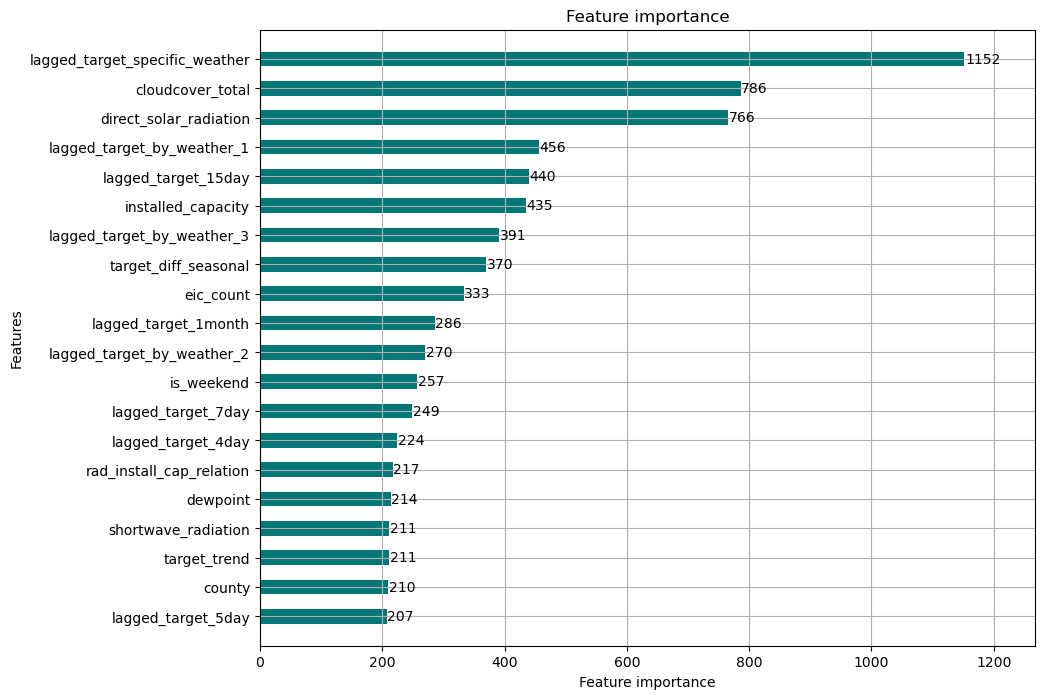

In [28]:
from lightgbm import plot_importance
import matplotlib.pyplot as plt

# Crear un gráfico de importancia de características
plot_importance(model_prod, height=0.5, figsize=(10, 8), importance_type='split', max_num_features=20, color='#007777')
plt.show()

*Podemos apreciar que las variables que hemos creado tienen mucha importancia para nuestro modelo*

<br>
<br>

### Predicción

In [29]:
# Predecimos con el modelo con hiperparametros

y_pred_prod = model_prod.predict(x_test_prod)
y_pred_train_prod = model_prod.predict(x_train_prod)

<br>
<br>

### Métricas

In [30]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Calcular métricas en el conjunto de entrenamiento
mae_train = mean_absolute_error(y_train_prod, y_pred_train_prod)
mse_train = mean_squared_error(y_train_prod, y_pred_train_prod)
r2_train = r2_score(y_train_prod, y_pred_train_prod)
rmse_train = mse_train**0.5

# Imprimir métricas en el conjunto de entrenamiento
print("Métricas en el conjunto de entrenamiento:")
print("MAE (Train):", mae_train)
print("MSE (Train):", mse_train)
print("RMSE (Train):", rmse_train)
print("R2 (Train):", r2_train)

# Calcular métricas en el conjunto de test
mae_test = mean_absolute_error(y_test_prod, y_pred_prod)
mse_test = mean_squared_error(y_test_prod, y_pred_prod)
r2_test = r2_score(y_test_prod, y_pred_prod)
rmse_test = mse_test**0.5

# Imprimir métricas en el conjunto de test
print("\nMétricas en el conjunto de test:")
print("MAE (Test):", mae_test)
print("MSE (Test):", mse_test)
print("RMSE (Test):", rmse_test)
print("R2 (Test):", r2_test)

Métricas en el conjunto de entrenamiento:
MAE (Train): 39.95688391826868
MSE (Train): 16263.950881418177
RMSE (Train): 127.53019595930282
R2 (Train): 0.9267331915213062

Métricas en el conjunto de test:
MAE (Test): 92.05073858140729
MSE (Test): 84726.031088015
RMSE (Test): 291.07736271997345
R2 (Test): 0.9421188582567458


*Vemos que en este modelo sufrimos overfitting, la predicción de la producción es bastante más compleja que la del consumo ya que afectan muchisimas variables (todas las climatologicas), por lo que debemos seguir trabajando en este modelo para conseguir reducir el overfitting*

<br>
<br>

# Modelo de Consumo

### Preparación del dataset

In [31]:
# Obtenemos la X y la Y para train y para test

x_train_con = df_train_con.drop(columns=['target'])
y_train_con = df_train_con.target

x_test_con = df_test_con.drop(columns=['target'])
y_test_con = df_test_con.target

<br>

### Entrenamiento del modelo

##### LightGBM

Nos decantamos por este modelo ya que nos daba los mejores resultados, junto con XGBoost, pero a diferencia de este ultimo su velocidad para procesar los datos es mucho mayor

Los hiperparametros elegidos son los que mejor resultado aportan

In [32]:
params = {
    'colsample_bytree': 1,
    'learning_rate': 0.01,
    'max_depth': 5,
    'n_estimators': 1800,
    'reg_alpha': 0.1,
    'reg_lambda': 0.1,
    'subsample': 1,
    'objective': 'regression',
    'metric': 'mae',
    'random_state': 99,
    'verbose': -1
}

model_con = LGBMRegressor(**params)
model_con.fit(x_train_con, y_train_con)

LGBMRegressor(colsample_bytree=1, learning_rate=0.01, max_depth=5, metric='mae',
              n_estimators=1800, objective='regression', random_state=99,
              reg_alpha=0.1, reg_lambda=0.1, subsample=1, verbose=-1)

<br>
<br>

##### Importancia de las variables

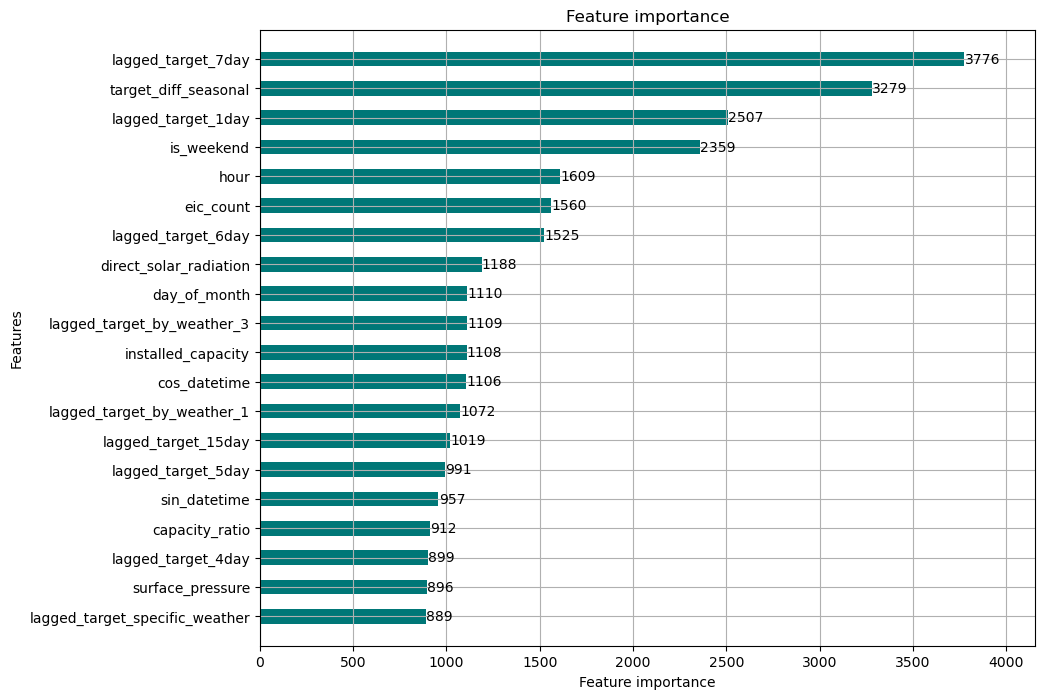

In [33]:
# Crear un gráfico de importancia de características
plot_importance(model_con, height=0.5, figsize=(10, 8), importance_type='split', max_num_features=20, color='#007777')
plt.show()

*Al igual que en el modelo de producción este modelo también le da mucha importancia a columnas creadas por nosotros*

<br>
<br>

### Predicción

In [34]:
# Predecimos con el modelo con hiperparametros

y_pred_con = model_con.predict(x_test_con)
y_pred_train_con = model_con.predict(x_train_con)

<br>
<br>

### Métricas

In [35]:
# Calcular métricas en el conjunto de entrenamiento
mae_train = mean_absolute_error(y_train_con, y_pred_train_con)
mse_train = mean_squared_error(y_train_con, y_pred_train_con)
r2_train = r2_score(y_train_con, y_pred_train_con)
rmse_train = mse_train**0.5

# Imprimir métricas en el conjunto de entrenamiento
print("Métricas en el conjunto de entrenamiento:")
print("MAE (Train):", mae_train)
print("MSE (Train):", mse_train)
print("RMSE (Train):", rmse_train)
print("R2 (Train):", r2_train)

# Calcular métricas en el conjunto de test
mae_test = mean_absolute_error(y_test_con, y_pred_con)
mse_test = mean_squared_error(y_test_con, y_pred_con)
r2_test = r2_score(y_test_con, y_pred_con)
rmse_test = mse_test**0.5

# Imprimir métricas en el conjunto de test
print("\nMétricas en el conjunto de test:")
print("MAE (Test):", mae_test)
print("MSE (Test):", mse_test)
print("RMSE (Test):", rmse_test)
print("R2 (Test):", r2_test)

Métricas en el conjunto de entrenamiento:
MAE (Train): 43.79616559710557
MSE (Train): 12377.916280666674
RMSE (Train): 111.25608424111768
R2 (Train): 0.9917405300498242

Métricas en el conjunto de test:
MAE (Test): 41.732629962369906
MSE (Test): 11599.348016219692
RMSE (Test): 107.70026934144451
R2 (Test): 0.9860392602208685


*En este modelo vemos que tenemos un resultado muchisimo mejor como podiamos prever por la propia naturaleza de la predicción.
En este caso no tenemos overfitting, de hecho tenemos un poco de underfitting pero es un muy buen resultado, por lo que nos centraremos actualmente en el modelo de producción*

<br>
<br>

# Conclusiones

Como hemos visto en las métricas de los dos modelos tenemos que centrarnos en el overfitting del modelo de producción, para ello nos gustaria poder tratar de manera diferente las variables de los dos modelos (cosa que no pudimos hacer antes por falta de tiempo)

Además como vimos en el describe que ejecutamos en el análisis EDA, tenemos unos valores atípicos extremadamente altos en nuestra variable target, lo que nos llevó a la conclusión de que si usabamos percentil 98 mejoraríamos nuestro modelo y así fue, dejamos aqui los resultados de dicho modelo:

**Modelo de Produccion (98%)**<br>
MAE (Train): 33.920383<br>
MSE (Train): 8844.317941<br>
RMSE (Train): 94.044233<br>
R2 (Train): 0.890221
<br>
<br>
MAE (Test): 55.695335<br>
MSE (Test): 16815.145899<br>
RMSE (Test): 129.673227<br>
R2 (Test): 0.937677

*Con este método hemos conseguido mejorar bastante la predicción del modelo y además reducir muchisimo el overfitting, aunque tenemos que seguir trabajando para reducirlo aún más*

<br>
<br>

**Modelo de Consumo (98%)**<br>
MAE (Train): 39.083107<br>
MSE (Train): 8444.740490<br>
RMSE (Train): 91.895269<br>
R2 (Train): 0.953727
<br>
<br>
MAE (Test): 36.10777<br>
MSE (Test): 4967.033418<br>
RMSE (Test): 70.477184<br>
R2 (Test): 0.946473

*Podemos observar que este modelo también hemos conseguido mejorarlo al usar percentil 98*

<br>
<br>

### OJO IMPORTANTE

Recomendamos ver el archivo de "explicacion_funciones", en el explicamos el código que usamos en las funciones del archivo "funciones.py"

!!Tienes que ver las funciones "historical_transformation" y "train_transformation"!!